In [1]:
%matplotlib inline
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 150

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
train_imputed = pd.read_csv('train_imputed.csv', index_col=0)
train_imputed.shape

(38385, 112)

In [8]:
train_imputed.columns.tolist()

['unit_id_institution',
 'college_name',
 'institution_control',
 'state_post_code',
 'zip_code',
 'city',
 'region_ipeds',
 'title_IV_eligibility',
 'pred_degree',
 'pred_degree_0and4',
 'degree_name',
 'degree_code',
 'major_code',
 'major_name',
 'branch_number',
 'avg_net_price_public',
 'avg_net_price_private',
 'full_time_net_tuition_revenue',
 'off_campus_cost_of_attendace',
 'on_campus_cost_of_attendace',
 'admission_rate',
 'graduate_number',
 'ACT_score_mid',
 'avg_sat_admitted',
 'required_score',
 'avg_faculty_salary',
 'online_only',
 'comp_rt_ft_150over_expected_time',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_black',
 'comp_rt_ft_150over_expected_time_hispanic',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race',
 'comp_rt_ft_150over_expected_time_white',
 'share_entering_students_first_ft'

In [3]:
train_imputed.unit_id_institution = train_imputed.unit_id_institution.astype(int)

In [4]:
# split the data
x_train_imputed = train_imputed.drop(columns = ['college_name','roi_5yr','pct_roi_5yr','roi_10yr','pct_roi_10yr',
                                                'roi_20yr','state_post_code','city','region_ipeds','institution_control',
                                                'pct_roi_20yr','major_name','major_category','zip_code','degree_name',
                                                'degree_code', 'avg_net_price','avg_net_price_public','online_only',
                                                'avg_net_price_private','2017','2018','2019','Grand Total'])
y_train_imputed = train_imputed[['roi_5yr']]

state_dummies_train = pd.get_dummies(train_imputed['state_post_code'])
region_dummies_train = pd.get_dummies(train_imputed['region_ipeds'])
institution_control_dummies_train = pd.get_dummies(train_imputed['institution_control'])

In [5]:
# scale the data
scaler = RobustScaler()
scaler.fit(x_train_imputed)

x_train_imputed_scaled = scaler.transform(x_train_imputed)
x_train_imputed_scaled = pd.DataFrame(x_train_imputed_scaled, columns=x_train_imputed.columns, 
                                      index=x_train_imputed.index)

x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled,state_dummies_train],axis=1)
x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled_with_dummy,region_dummies_train],axis=1)
x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled_with_dummy,institution_control_dummies_train],axis=1)

In [6]:
x_train_imputed_scaled_with_dummy.head()

,unit_id_institution,title_IV_eligibility,pred_degree,pred_degree_0and4,major_code,branch_number,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,FL,FM,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MH,MI,MN,MO,MP,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,midwest,northeast,southeast,southwest,territory,west,"Private, for-profit","Private, nonprofit",Public
25656,-0.337953,0.0,0.0,0.0,-0.441211,1.0,-0.234229,-0.703494,-0.769784,0.504091,-0.220206,-0.156567,-0.019251,1.274994,-0.760883,-0.968949,-0.794057,-0.864228,-0.990535,-0.791507,-0.873331,-0.635783,-0.884938,-1.033084,-1.162945,1.583104,-1.054557,-0.225049,0.404762,0.307692,-0.208426,0.341799,-0.426471,0.210526,-0.517316,-0.417367,0.564353,0.907444,0.207499,0.227273,-0.064533,-0.308875,-0.058704,0.911825,0.0028,-0.129310,0.0,0.00000,-0.398482,0.0004,1.561688,0.0,-0.398582,0.082883,14.0,0.177570,5.363636,0.0079,-0.841026,0.106494,0.0,-0.917415,-0.677686,0.0,-0.297710,-0.332661,-0.390625,0.0,-0.602151,0.0,-0.920000,0.462527,-0.231047,-0.581619,0.0,0.0,0.0,0.0,-0.647668,1.416565,0.795937,-0.819672,1.065708,0.418033,0.195312,0.031008,-0.120968,-0.327014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28625,0.409602,0.0,0.0,0.0,0.031158,0.0,0.763736,-0.469783,1.06

### cluster 1. basic info of school

In [ ]:
'unit_id_institution','title_IV_eligibility','admission_rate','branch_number','graduate_number'

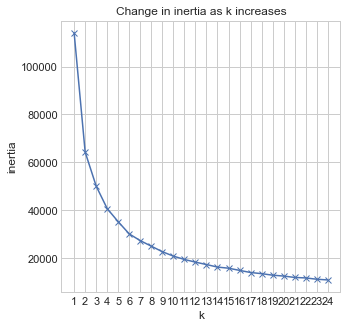

In [7]:
x1 = x_train_imputed_scaled_with_dummy[['unit_id_institution','title_IV_eligibility','admission_rate','branch_number','graduate_number']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x1).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 6

In [8]:
kmeans1 = KMeans(n_clusters=6)
kmeans1.fit(x1)

cluster_basic_info = kmeans1.predict(x1)
x_train_imputed_scaled_with_dummy['cluster_basic_info'] = cluster_basic_info

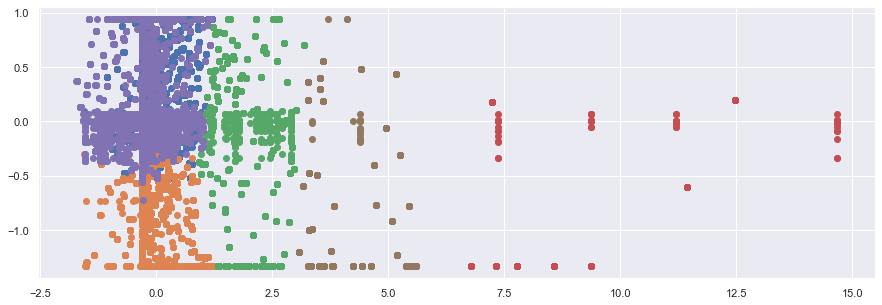

In [10]:
plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.cluster_basic_info.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_basic_info == 
                                          cluster_n].graduate_number, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_basic_info == cluster_n].
                admission_rate, label=f'cluster_{cluster_n}')

### cluster 2. location and income

In [ ]:
'income_0_30000','income_30001_48000','income_48001_75000','income_75001_110000','income_over_110000',
'AK','AL','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA',
'MD','ME','MH','MI','MN','MO','MP','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','RI',
'SC','SD','TN','TX','UT','VA','VI','VT','WA','WI','WV','WY','midwest','northeast','southeast','southwest','west',
'territory'

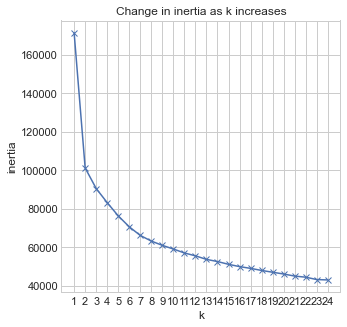

In [11]:
x2 = x_train_imputed_scaled_with_dummy[['income_0_30000','income_30001_48000','income_48001_75000',
                                        'income_75001_110000','income_over_110000','AK','AL','AR','AS','AZ','CA','CO',
                                        'CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA',
                                        'MA','MD','ME','MH','MI','MN','MO','MP','MS','MT','NC','ND','NE','NH','NJ',
                                        'NM','NV','NY','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VA',
                                        'VI','VT','WA','WI','WV','WY','midwest','northeast','southeast','southwest',
                                        'west','territory']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x2).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 6

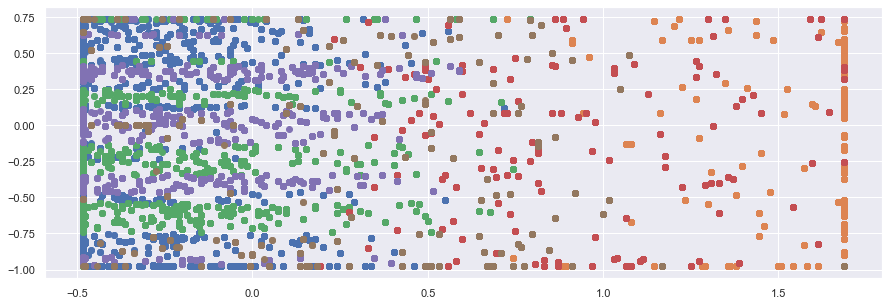

In [12]:
kmeans2 = KMeans(n_clusters=6)
kmeans2.fit(x2)

cluster_location_income = kmeans2.predict(x2)
x_train_imputed_scaled_with_dummy['cluster_location_income'] = cluster_location_income

plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.cluster_location_income.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_location_income == cluster_n].
                income_75001_110000, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_location_income == cluster_n].
                unit_id_institution, label=f'cluster_{cluster_n}')

### cluster 3. degree

In [ ]:
'avg_sat_admitted','deg_percent_awarded_agriculture_operations',
                                        'deg_percent_awarded_natural_resources','deg_percent_awarded_architecture',
                                        'deg_percent_awarded_area_ethnic_cultural_gender','deg_percent_awarded_communication_journalism',
                                        'deg_percent_awarded_communication_tech','deg_percent_awarded_computer_science',
                                        'deg_percent_awarded_personal_culinary_services',
                                        'deg_percent_awarded_education','deg_percent_awarded_engineering',
                                        'deg_percent_awarded_engineering_tech','deg_percent_awarded_foreign_language_literatures',
                                        'deg_percent_awarded_human_science','deg_percent_awarded_legal_profession',
                                        'deg_percent_awarded_english_lang','deg_percent_awarded_general_studies',
                                        'deg_percent_awarded_library_sciences','deg_percent_awarded_bio_sciences',
                                        'deg_percent_awarded_mathematics','deg_percent_awarded_military_tech',
                                        'deg_percent_awarded_intedisciplinary_studies','deg_percent_awarded_leisure_fitness',
                                        'deg_percent_awarded_philosophy','deg_percent_awarded_theology',
                                        'deg_percent_awarded_physical_sciences','deg_percent_awarded_science_tech',
                                        'deg_percent_awarded_psychology','deg_percent_awarded_homeland_security',
                                        'deg_percent_awarded_public_admin','deg_percent_awarded_social_sciences',
                                        'deg_percent_awarded_construction_trades','deg_percent_awarded_mechanic_repair',
                                        'deg_percent_awarded_precision_production','deg_percent_awarded_transportation_materials',
                                        'deg_percent_awarded_visual_and_performing_arts','deg_percent_awarded_health',
                                        'deg_percent_awarded_business_management','deg_percent_awarded_history'

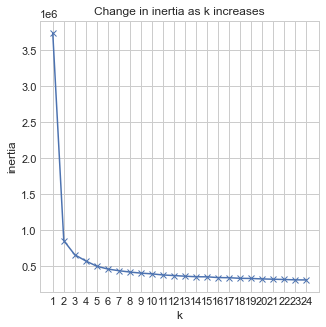

In [13]:
x3 = x_train_imputed_scaled_with_dummy[['deg_percent_awarded_agriculture_operations',
                                        'deg_percent_awarded_natural_resources','deg_percent_awarded_architecture',
                                        'deg_percent_awarded_area_ethnic_cultural_gender','deg_percent_awarded_communication_journalism',
                                        'deg_percent_awarded_communication_tech','deg_percent_awarded_computer_science',
                                        'deg_percent_awarded_personal_culinary_services',
                                        'deg_percent_awarded_education','deg_percent_awarded_engineering',
                                        'deg_percent_awarded_engineering_tech','deg_percent_awarded_foreign_language_literatures',
                                        'deg_percent_awarded_human_science','deg_percent_awarded_legal_profession',
                                        'deg_percent_awarded_english_lang','deg_percent_awarded_general_studies',
                                        'deg_percent_awarded_library_sciences','deg_percent_awarded_bio_sciences',
                                        'deg_percent_awarded_mathematics','deg_percent_awarded_military_tech',
                                        'deg_percent_awarded_intedisciplinary_studies','deg_percent_awarded_leisure_fitness',
                                        'deg_percent_awarded_philosophy','deg_percent_awarded_theology',
                                        'deg_percent_awarded_physical_sciences','deg_percent_awarded_science_tech',
                                        'deg_percent_awarded_psychology','deg_percent_awarded_homeland_security',
                                        'deg_percent_awarded_public_admin','deg_percent_awarded_social_sciences',
                                        'deg_percent_awarded_construction_trades','deg_percent_awarded_mechanic_repair',
                                        'deg_percent_awarded_precision_production','deg_percent_awarded_transportation_materials',
                                        'deg_percent_awarded_visual_and_performing_arts','deg_percent_awarded_health',
                                        'deg_percent_awarded_business_management','deg_percent_awarded_history']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x3).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* K = 3

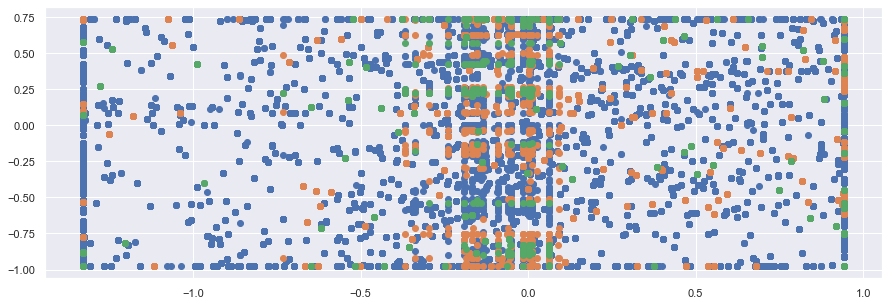

In [18]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit(x3)

cluster_degree = kmeans3.predict(x3)
x_train_imputed_scaled_with_dummy['cluster_degree'] = cluster_degree

plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.cluster_degree.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_degree == cluster_n].
                admission_rate, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_degree == cluster_n].
                unit_id_institution, label=f'cluster_{cluster_n}')

### cluster 4. SAT score and race

In [ ]:
'avg_sat_admitted', 'enrollment_share_two_races','enrollment_share_native_american','enrollment_share_asian',
'enrollment_share_black','enrollment_share_hispanic','enrollment_share_pac_islander','enrollment_share_non_resident',
'enrollment_share_unknown','enrollment_share_white'

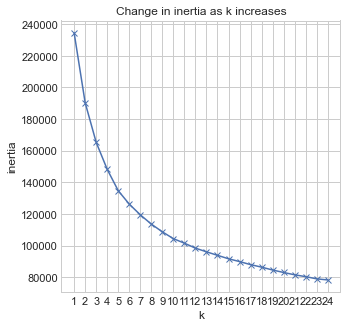

In [19]:
x4 = x_train_imputed_scaled_with_dummy[['avg_sat_admitted', 'enrollment_share_two_races','enrollment_share_native_american','enrollment_share_asian',
                                        'enrollment_share_black','enrollment_share_hispanic','enrollment_share_pac_islander','enrollment_share_non_resident',
                                        'enrollment_share_unknown','enrollment_share_white']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x4).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 5

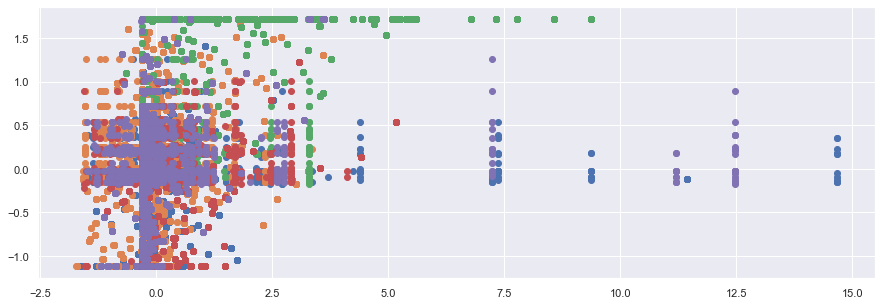

In [22]:
kmeans4 = KMeans(n_clusters=5)
kmeans4.fit(x4)

cluster_sat_race = kmeans4.predict(x4)
x_train_imputed_scaled_with_dummy['cluster_sat_race'] = cluster_sat_race

plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.cluster_sat_race.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_sat_race == cluster_n].
                graduate_number, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_sat_race == cluster_n].
                avg_sat_admitted,label=f'cluster_{cluster_n}')

### cluster 5. debt

In [ ]:
'undergraduate_number_pell_grant_fedral_loan','med_debt_pell_students','median_debt_completed','median_debt_non_pell',
'fedral_loan_full_time_first_time_undergraduate','pell_grant_full_time_first_time_undergraduate'

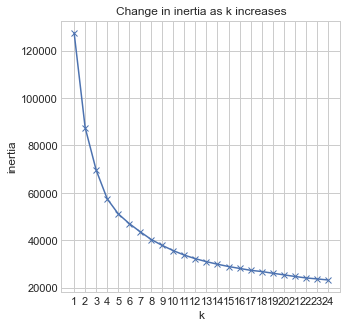

In [23]:
x5 = x_train_imputed_scaled_with_dummy[['undergraduate_number_pell_grant_fedral_loan','med_debt_pell_students','median_debt_completed','median_debt_non_pell',
                                        'fedral_loan_full_time_first_time_undergraduate','pell_grant_full_time_first_time_undergraduate']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x5).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 5

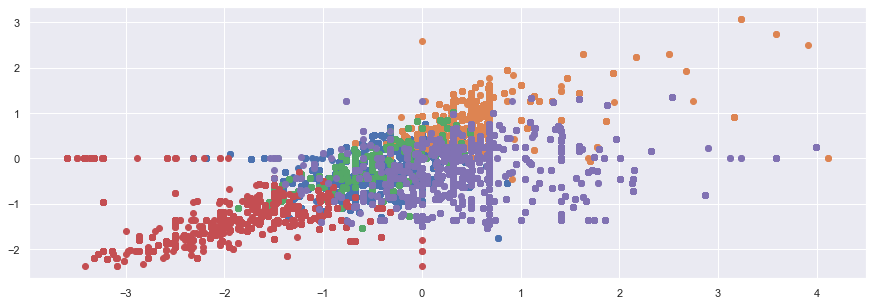

In [24]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(x5)

cluster_debt = kmeans5.predict(x5)
x_train_imputed_scaled_with_dummy['cluster_debt'] = cluster_debt

plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.cluster_debt.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_debt == cluster_n].
                median_debt_completed, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.cluster_debt == cluster_n].
                med_debt_pell_students,label=f'cluster_{cluster_n}')

In [26]:
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['cluster_basic_info'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['cluster_location_income'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['cluster_degree'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['cluster_sat_race'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['cluster_debt'])

## 1. select k best

In [27]:
# drop columns have null value
col = ['median_debt_non_first_generation']
x_train_imputed_scaled_with_dummy = x_train_imputed_scaled_with_dummy.drop(columns = col)

In [40]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

kbest = SelectKBest(f_regression, k=50)
kbest.fit(x_train_imputed_scaled_with_dummy, y_train_imputed)

kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train_imputed_scaled_with_dummy.columns)
x_train_imputed_scaled_with_dummy.columns[kbest.get_support()]

Index(['branch_number', 'full_time_net_tuition_revenue',
       'on_campus_cost_of_attendace', 'comp_rt_ft_150over_expected_time',
       'comp_rt_ft_150over_expected_time_two_races',
       'comp_rt_ft_150over_expected_time_asian',
       'comp_rt_ft_150over_expected_time_hispanic',
       'comp_rt_ft_150over_expected_time_non_resident',
       'comp_rt_ft_150over_expected_time_unknown_race',
       'comp_rt_ft_150over_expected_time_white',
       'share_entering_students_first_ft', 'share_of_part_time',
       'enrollment_share_hispanic', 'enrollment_share_non_resident',
       'enrollment_share_white', 'undergraduate_number_pell_grant_fedral_loan',
       'med_debt_pell_students', 'median_debt_completed',
       'median_debt_non_pell',
       'fedral_loan_full_time_first_time_undergraduate',
       'pell_grant_full_time_first_time_undergraduate',
       'deg_percent_awarded_computer_science',
       'deg_percent_awarded_engineering_tech',
       'deg_percent_awarded_english_lang',
 

### 2. Recursive Feature Elimination (RFE)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lm = LinearRegression()

rfe = RFE(lm, n_features_to_select=20)

rfe.fit(x_train_imputed_scaled_with_dummy,y_train_imputed)  

feature_mask = rfe.support_

rfe_feature = x_train_imputed_scaled_with_dummy.iloc[:,feature_mask].columns.tolist()
rfe_feature

['Private, for-profit',
 'Private, nonprofit',
 'Public',
 'cluster_basic_info_0',
 'cluster_basic_info_1',
 'cluster_basic_info_2',
 'cluster_basic_info_3',
 'cluster_basic_info_4',
 'cluster_basic_info_5',
 'cluster_degree_0',
 'cluster_sat_race_0',
 'cluster_sat_race_1',
 'cluster_sat_race_2',
 'cluster_sat_race_3',
 'cluster_sat_race_4',
 'cluster_debt_0',
 'cluster_debt_1',
 'cluster_debt_2',
 'cluster_debt_3',
 'cluster_debt_4']

In [31]:
validate_imputed = pd.read_csv('validate_imputed.csv')

In [32]:
#Establish baselines for the train and validation subsets
baseline = train_imputed.roi_5yr.mean()

train_imputed['baseline'] = baseline
validate_imputed['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train_imputed.roi_5yr, train_imputed.baseline))
validate_rmse = sqrt(mean_squared_error(validate_imputed.roi_5yr, validate_imputed.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.38174842144612947.
Validation baseline RMSE: 0.38033342886322746.


In [34]:
# use the features from select k best
x_train_k_best = x_train_imputed_scaled_with_dummy[['full_time_net_tuition_revenue', 'on_campus_cost_of_attendace',
       'comp_rt_ft_150over_expected_time',
       'comp_rt_ft_150over_expected_time_two_races',
       'comp_rt_ft_150over_expected_time_non_resident',
       'comp_rt_ft_150over_expected_time_white',
       'share_entering_students_first_ft', 'share_of_part_time',
       'enrollment_share_white', 'undergraduate_number_pell_grant_fedral_loan',
       'med_debt_pell_students', 'median_debt_completed',
       'median_debt_non_pell', 'pell_grant_full_time_first_time_undergraduate',
       'deg_percent_awarded_engineering_tech',
       'deg_percent_awarded_english_lang', 'deg_percent_awarded_bio_sciences',
       'deg_percent_awarded_philosophy',
       'deg_percent_awarded_homeland_security',
       'deg_percent_awarded_visual_and_performing_arts', 'non_deg_seeking',
       'income_0_30000', 'Private, for-profit', 'Private, nonprofit', 'Public',
       'cluster_location_income_5', 'cluster_degree_0', 'cluster_sat_race_3',
       'cluster_debt_1', 'cluster_debt_3']]

predictions_train_k_best_model = pd.DataFrame({'actual': train_imputed.roi_5yr})
predictions_train_k_best_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['lm'] = lm.predict(x_train_k_best)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['lasso_lars'] = lars.predict(x_train_k_best)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['glm'] = glm.predict(x_train_k_best)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_k_best)
x_train_k_best_poly = pd.DataFrame(poly.transform(x_train_k_best),
                                   columns=poly.get_feature_names(x_train_k_best.columns),index=train_imputed.index)
lm1 = LinearRegression()
lm1.fit(x_train_k_best_poly, y_train_imputed)
x_train_k_best_poly = poly.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_degree_2'] = lm1.predict(x_train_k_best_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_k_best)
x_train_k_best_poly1 = pd.DataFrame(poly1.transform(x_train_k_best),
                                    columns=poly1.get_feature_names(x_train_k_best.columns),index=train_imputed.index)
lm1.fit(x_train_k_best_poly1, y_train_imputed)
x_train_k_best_poly1 = poly1.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_only_interaction'] = lm1.predict(x_train_k_best_poly1)
predictions_train_k_best_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
25656,0.3668,0.367744,0.414858,0.367744,0.479232,0.571810,0.568843
28625,0.3791,0.367744,0.135217,0.367744,0.225920,0.119888,0.103732
36032,0.1508,0.367744,0.201250,0.367744,0.311819,0.210986,0.242452
30254,-0.0548,0.367744,0.146215,0.367744,0.238613,0.129808,0.168479
68185,0.1611,0.367744,0.172596,0.367744,0.233886,0.143082,0.151350


In [35]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_k_best_model.actual, y_predicted))
predictions_train_k_best_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.322744
polynomial_only_interaction    0.323491
lm                             0.338917
glm                            0.349893
baseline                       0.381748
lasso_lars                     0.381748
dtype: float64

In [38]:
# RFE
x_train_rfe = x_train_imputed_scaled_with_dummy[['Private, for-profit',
 'Private, nonprofit',
 'Public',
 'cluster_basic_info_0',
 'cluster_basic_info_1',
 'cluster_basic_info_2',
 'cluster_basic_info_3',
 'cluster_basic_info_4',
 'cluster_basic_info_5',
 'cluster_degree_0',
 'cluster_sat_race_0',
 'cluster_sat_race_1',
 'cluster_sat_race_2',
 'cluster_sat_race_3',
 'cluster_sat_race_4',
 'cluster_debt_0',
 'cluster_debt_1',
 'cluster_debt_2',
 'cluster_debt_3',
 'cluster_debt_4']]
predictions_train_rfe_model = pd.DataFrame({'actual': train_imputed.roi_5yr})
predictions_train_rfe_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_rfe, y_train_imputed)
predictions_train_rfe_model['lm'] = lm.predict(x_train_rfe)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_rfe, y_train_imputed)
predictions_train_rfe_model['lasso_lars'] = lars.predict(x_train_rfe)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_rfe, y_train_imputed)
predictions_train_rfe_model['glm'] = glm.predict(x_train_rfe)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_rfe)
x_train_rfe_poly = pd.DataFrame(
    poly.transform(x_train_rfe),
    columns=poly.get_feature_names(x_train_rfe.columns),
    index=train_imputed.index)
lm1 = LinearRegression()
lm1.fit(x_train_rfe_poly, y_train_imputed)
x_train_rfe_poly = poly.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_degree_2'] = lm1.predict(x_train_rfe_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_rfe)
x_train_rfe_poly1 = pd.DataFrame(
    poly1.transform(x_train_rfe),
    columns=poly1.get_feature_names(x_train_rfe.columns),
    index=train_imputed.index)
lm1.fit(x_train_rfe_poly1, y_train_imputed)
x_train_poly1 = poly1.transform(x_train_rfe)
predictions_train_rfe_model['polynomial_only_interaction'] = lm1.predict(x_train_rfe_poly1)
predictions_train_rfe_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
25656,0.3668,0.367744,0.317749,0.367744,0.345706,0.339600,0.339355
28625,0.3791,0.367744,0.212097,0.367744,0.310861,0.197388,0.195190
36032,0.1508,0.367744,0.292053,0.367744,0.341385,0.265503,0.269775
30254,-0.0548,0.367744,0.212097,0.367744,0.310861,0.197388,0.195190
68185,0.1611,0.367744,0.267395,0.367744,0.325932,0.180786,0.174561


In [39]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_rfe_model.actual, y_predicted))
predictions_train_rfe_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.344589
polynomial_only_interaction    0.344596
lm                             0.350299
glm                            0.366351
baseline                       0.381748
lasso_lars                     0.381748
dtype: float64

In [ ]:
# with seleck k best 50 features

In [41]:
x_train_k_best = x_train_imputed_scaled_with_dummy[['branch_number', 'full_time_net_tuition_revenue',
       'on_campus_cost_of_attendace', 'comp_rt_ft_150over_expected_time',
       'comp_rt_ft_150over_expected_time_two_races',
       'comp_rt_ft_150over_expected_time_asian',
       'comp_rt_ft_150over_expected_time_hispanic',
       'comp_rt_ft_150over_expected_time_non_resident',
       'comp_rt_ft_150over_expected_time_unknown_race',
       'comp_rt_ft_150over_expected_time_white',
       'share_entering_students_first_ft', 'share_of_part_time',
       'enrollment_share_hispanic', 'enrollment_share_non_resident',
       'enrollment_share_white', 'undergraduate_number_pell_grant_fedral_loan',
       'med_debt_pell_students', 'median_debt_completed',
       'median_debt_non_pell',
       'fedral_loan_full_time_first_time_undergraduate',
       'pell_grant_full_time_first_time_undergraduate',
       'deg_percent_awarded_computer_science',
       'deg_percent_awarded_engineering_tech',
       'deg_percent_awarded_english_lang',
       'deg_percent_awarded_general_studies',
       'deg_percent_awarded_bio_sciences', 'deg_percent_awarded_mathematics',
       'deg_percent_awarded_philosophy', 'deg_percent_awarded_theology',
       'deg_percent_awarded_homeland_security',
       'deg_percent_awarded_social_sciences',
       'deg_percent_awarded_visual_and_performing_arts',
       'deg_percent_awarded_history', 'non_deg_seeking', 'income_0_30000',
       'income_30001_48000', 'income_over_110000', 'PR', 'northeast',
       'territory', 'Private, for-profit', 'Private, nonprofit', 'Public',
       'cluster_location_income_5', 'cluster_degree_0', 'cluster_degree_1',
       'cluster_sat_race_2', 'cluster_sat_race_3', 'cluster_debt_1',
       'cluster_debt_3']]

predictions_train_k_best_model = pd.DataFrame({'actual': train_imputed.roi_5yr})
predictions_train_k_best_model['baseline'] = baseline

lm = LinearRegression()
lm.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['lm'] = lm.predict(x_train_k_best)

lars = LassoLars(alpha=1.0)
lars.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['lasso_lars'] = lars.predict(x_train_k_best)

glm = TweedieRegressor(power=0, alpha=1)
glm.fit(x_train_k_best, y_train_imputed)
predictions_train_k_best_model['glm'] = glm.predict(x_train_k_best)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_k_best)
x_train_k_best_poly = pd.DataFrame(poly.transform(x_train_k_best),
                                   columns=poly.get_feature_names(x_train_k_best.columns),index=train_imputed.index)
lm1 = LinearRegression()
lm1.fit(x_train_k_best_poly, y_train_imputed)
x_train_k_best_poly = poly.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_degree_2'] = lm1.predict(x_train_k_best_poly)

poly1 = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly1.fit(x_train_k_best)
x_train_k_best_poly1 = pd.DataFrame(poly1.transform(x_train_k_best),
                                    columns=poly1.get_feature_names(x_train_k_best.columns),index=train_imputed.index)
lm1.fit(x_train_k_best_poly1, y_train_imputed)
x_train_k_best_poly1 = poly1.transform(x_train_k_best)
predictions_train_k_best_model['polynomial_only_interaction'] = lm1.predict(x_train_k_best_poly1)
predictions_train_k_best_model.head()

,actual,baseline,lm,lasso_lars,glm,polynomial_degree_2,polynomial_only_interaction
25656,0.3668,0.367744,0.591961,0.367744,0.515050,0.769411,0.767414
28625,0.3791,0.367744,0.128308,0.367744,0.229020,0.138298,0.118586
36032,0.1508,0.367744,0.163147,0.367744,0.305920,0.175042,0.187963
30254,-0.0548,0.367744,0.176216,0.367744,0.222069,0.216916,0.207462
68185,0.1611,0.367744,0.165610,0.367744,0.234177,0.244615,0.248272


In [42]:
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions_train_k_best_model.actual, y_predicted))
predictions_train_k_best_model.apply(calculate_rmse).sort_values()

actual                         0.000000
polynomial_degree_2            0.312490
polynomial_only_interaction    0.313020
lm                             0.335577
glm                            0.347812
baseline                       0.381748
lasso_lars                     0.381748
dtype: float64